# CNN Model
Some basic augmentation

600 positive cases

5000 negative cases

## Import Libraries

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import keras.backend as K

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers


import csv
import random
import pickle

## Load downsampled dataset

In [3]:
# Load the compressed array from disk
images_mini = np.load('CNN_Xs_downsample.npz')['data']

In [4]:
# load the labels from disk
with open('CNN_labels_downsampled.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [5]:
print('images_mini.shape:', images_mini.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (5600, 53248)

number of labels: 5600

number of positive cancer cases: 600


## Normalize pixel values to [0,1] range

In [6]:
print('Original max pixel value:', images_mini.max())
print('Confirm min pixel value is 0:', images_mini.min())

Original max pixel value: 0.062455176623178454
Confirm min pixel value is 0: 0.0


In [7]:
#Normalize image pixel values
images_mini_norm = images_mini / images_mini.max() 

In [8]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 1.0
Confirm min pixel value is 0: 0.0


## Make all images 3D instead of 1D

In [9]:
images_mini_norm.shape

(5600, 53248)

In [10]:
n_img,n_pix = images_mini_norm.shape
images_mini_norm = images_mini_norm.reshape(n_img,256,208,1)
images_mini_norm.shape

(5600, 256, 208, 1)

## resize all images for vgg16 expected input

In [11]:
# Load the images as a NumPy array
images = images_mini_norm  # shape: (n_img, 256, 208, 1)

# Define the desired size
size = (224, 224)

# Define a function to resize each image
def resize_image(image):
    resized_image = tf.image.resize(image, size=size)
    return resized_image

# Apply the function to each image using tf.map_fn
resized_images = tf.map_fn(resize_image, images, dtype=tf.float32)


In [12]:
# Load a batch of grayscale images as a NumPy array
gray_images = resized_images  # shape: (n_img, height, width, 1)

# Convert each grayscale image to an RGB image using tf.map_fn
def grayscale_to_rgb(image):
    return tf.tile(image, multiples=[1, 1, 3])  # shape: (height, width, 3)

rgb_images = tf.map_fn(grayscale_to_rgb, gray_images, dtype=tf.float32)


In [13]:
images_mini_norm = rgb_images.numpy()

In [14]:
print('Original max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

Original max pixel value: 1.0
Confirm min pixel value is 0: 0.0


In [15]:
#Normalize image pixel values
images_mini_norm = images_mini_norm  *255

In [16]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 255.0
Confirm min pixel value is 0: 0.0


## Visualize image transformations

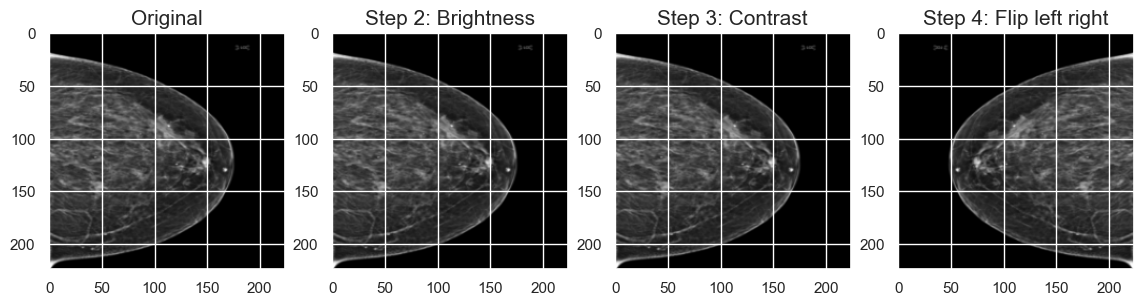

In [18]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini_norm[0]

# plot original
ax = fig.add_subplot(1, 4, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);


# adjust brightness
ax = fig.add_subplot(1, 4, 2)
img_bright = tf.image.adjust_brightness(image, -.8)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 4, 3)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 4, 4)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);


## Split data into train, validate, test

In [19]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; 
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 1)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 1)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 1)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images = images[shuffle]
    y = y[shuffle]
    
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [20]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini_norm,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"y_train positive cases {sum(y_train)}\n")

print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"y_val positive cases {sum(y_val)}\n")

print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")
print(f"y_test positive cases {sum(y_test)}\n")

X_train shape (3360, 224, 224, 3)
y_train shape (3360,)
y_train positive cases 371

X_val shape (1120, 224, 224, 3)
y_val shape (1120,)
y_val positive cases 114

X_test shape (1120, 224, 224, 3)
y_test shape (1120,)
y_test positive cases 115



## No Augmentation

## Build vgg16 model

In [50]:
IMG_SIZE = 224
IMG_SHAPE = ( IMG_SIZE, IMG_SIZE, 3)
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
VGG16_MODEL.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')

model = tf.keras.Sequential([
  VGG16_MODEL,
  global_average_layer,
  prediction_layer
])

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['AUC','accuracy'])

In [53]:
history = model.fit(X_train, y_train,
                    epochs=10, 
                    validation_data=(X_val, y_val)
)

Epoch 1/10
105/105 [==============================] - 495s 5s/step - loss: 0.4280 - auc: 0.5457 - accuracy: 0.8661 - val_loss: 0.4042 - val_auc: 0.5551 - val_accuracy: 0.8938
Epoch 2/10
105/105 [==============================] - 512s 5s/step - loss: 0.3857 - auc: 0.5790 - accuracy: 0.8756 - val_loss: 0.3776 - val_auc: 0.5667 - val_accuracy: 0.8741
Epoch 3/10
105/105 [==============================] - 495s 5s/step - loss: 0.3732 - auc: 0.6023 - accuracy: 0.8804 - val_loss: 0.3649 - val_auc: 0.5735 - val_accuracy: 0.8973
Epoch 4/10
105/105 [==============================] - 489s 5s/step - loss: 0.3534 - auc: 0.6296 - accuracy: 0.8851 - val_loss: 0.3539 - val_auc: 0.5841 - val_accuracy: 0.8884
Epoch 5/10
105/105 [==============================] - 474s 5s/step - loss: 0.3447 - auc: 0.6505 - accuracy: 0.8854 - val_loss: 0.3527 - val_auc: 0.5949 - val_accuracy: 0.8973
Epoch 6/10
105/105 [==============================] - 483s 5s/step - loss: 0.3417 - auc: 0.6572 - accuracy: 0.8866 - val_loss

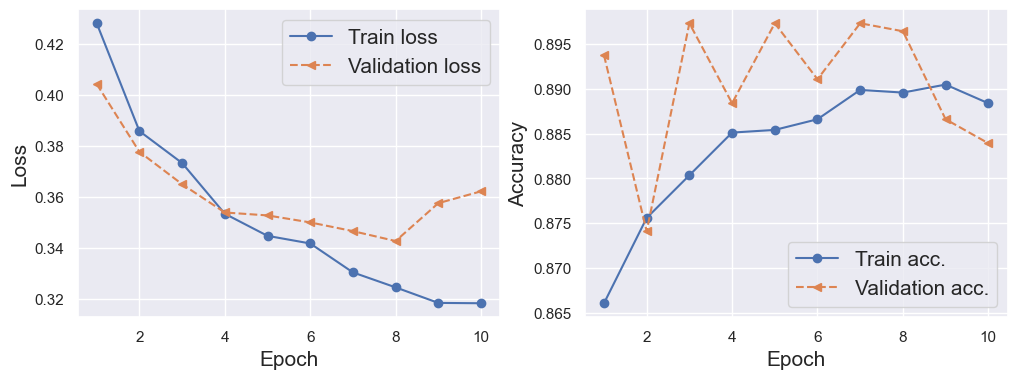

In [54]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

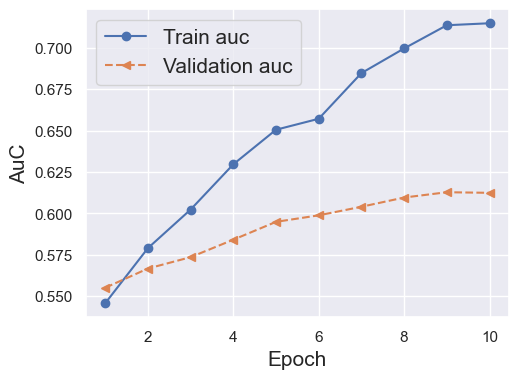

In [55]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))


ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['auc'], '-o', label='Train auc')
ax.plot(x_arr, hist['val_auc'], '--<', label='Validation auc')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('AuC', size=15)
plt.show()